In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  i

In [6]:
# 3
import pandas as pd
train_image_generator = ImageDataGenerator(rescale=1.0 / 255)
validation_image_generator = ImageDataGenerator(rescale=1.0 / 255)
test_image_generator = ImageDataGenerator(rescale=1.0 / 255)

# Load images from directories
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'  # Binary classification (cats vs. dogs)
)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)


# Get a list of test image file names
test_filenames = os.listdir(test_dir)

# List only valid image files
test_filenames = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Create DataFrame
test_df = pd.DataFrame({'filename': test_filenames})

# Create test data generator
test_data_gen = test_image_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col="filename",
    y_col=None,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 validated image filenames.


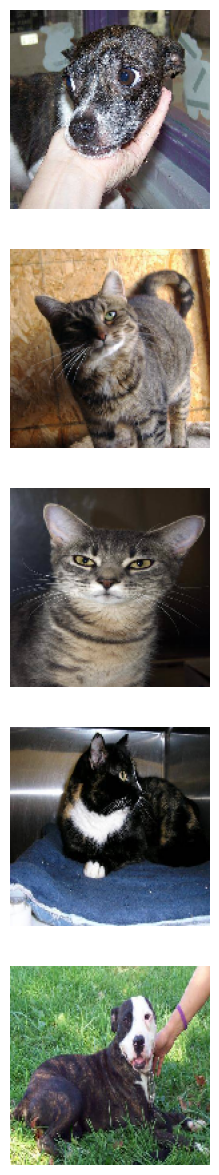

In [7]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [8]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1.0 / 255,   # Normalize pixel values
    rotation_range=40,   # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20%
    height_shift_range=0.2,  # Randomly shift images vertically by 20%
    shear_range=0.2,  # Apply random shearing transformations
    zoom_range=0.2,   # Randomly zoom into images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels after transformations
)

Found 2000 images belonging to 2 classes.


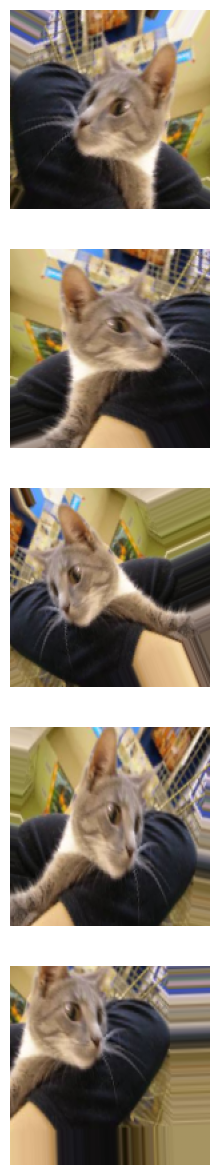

In [9]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [10]:
# 7
model = Sequential([
    # Convolutional layers with MaxPooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten layer to feed into Dense layers
    Flatten(),

    # Fully connected layers
    Dense(512, activation='relu'),
    Dropout(0.5),  # Reduce overfitting
    Dense(1, activation='sigmoid')  # Binary classification (cats vs. dogs)
])

# Compile the model
model.compile(
    optimizer='adam',  # Adam optimizer
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']  # Track accuracy
)

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # Convolutional layers with Batch Normalization
    Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # GlobalAveragePooling reduces parameters and improves generalization
    GlobalAveragePooling2D(),

    # Fully connected layers
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with Adam optimizer and lower learning rate
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()  # Print model architecture

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 75, 75, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,952,129 (7.45 MB)

 Trainable params: 1,950,209 (7.44 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [24]:
# 8
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 440s 29s/step - accuracy: 0.7049 - loss: 0.5736 - val_accuracy: 0.5033 - val_loss: 0.8797
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.6406 - loss: 0.6205 - val_accuracy: 0.5078 - val_loss: 0.8791
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 502s 31s/step - accuracy: 0.6888 - loss: 0.5743 - val_accuracy: 0.5022 - val_loss: 0.9238
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.7188 - loss: 0.5893 - val_accuracy: 0.5078 - val_loss: 0.9229
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 435s 30s/step - accuracy: 0.7030 - loss: 0.5722 - val_accuracy: 0.4922 - val_loss: 0.9711
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.7188 - loss: 0.5724 - val_accuracy: 0.5045 - val_loss: 0.9492
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 502s 31s/step - accuracy: 0.6976 - loss: 0.5655 - val_accuracy: 0.4978 - val_loss: 1.1034
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.7188 - loss: 0.5901 - val_accuracy: 0.5067 - v

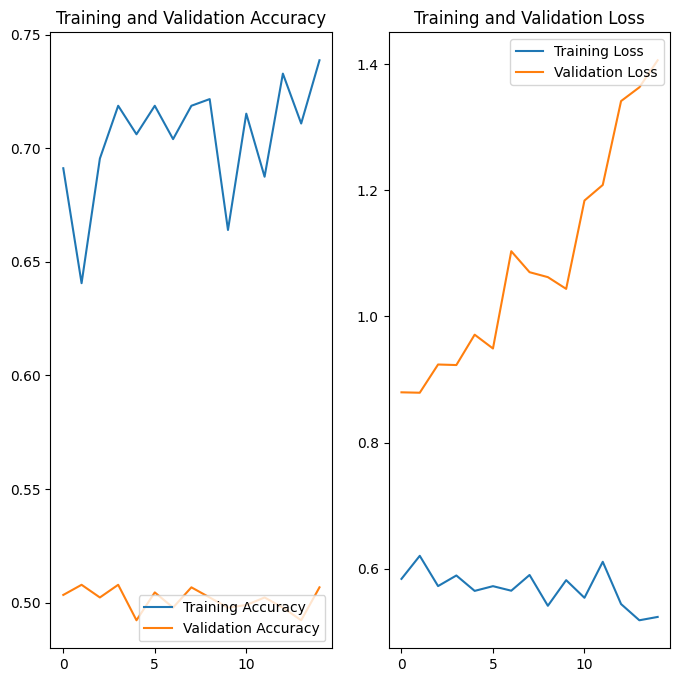

In [25]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# prompt: In this cell, get the probability that each test image (from test_data_gen) is a dog or a cat. probabilities should be a list of integers.

probabilities = model.predict(test_data_gen)
probabilities = [prob[0] for prob in probabilities]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


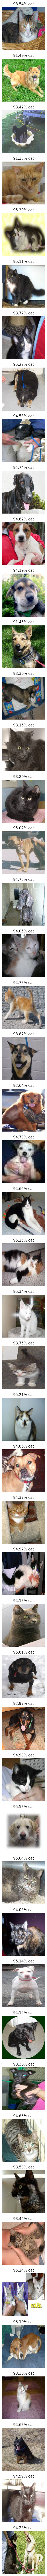

In [27]:
# prompt: Call the plotImages function and pass in the test images and the probabilities corresponding to each test image

# Assuming test_images and probabilities are defined elsewhere in your code
# Example:
# test_images = ...  # Load your test images here
# probabilities = model.predict(test_data_gen) # Get the predictions

# Assuming test_images is the test_data_gen
test_images = test_data_gen
probabilities = model.predict(test_images)
probabilities = [prob[0] for prob in probabilities]

# Now plot the images with their probabilities
plotImages(test_images[0], probabilities[:len(test_images[0])])


In [28]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 52.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
